# Obtaining communities
The goal of this part is to extract communities in a structural graph. The graph is based on DTI data, subject-wise.
First, we'll perform community detection, relying on Louvain's algorithm coupled with consensus clustering (co-occurence based).

In [1]:
from scipy.io import loadmat
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

import nilearn
from nilearn.datasets import fetch_atlas_aal
import nilearn.plotting as plotting
import numpy as np

/home/guibertf/nilearn/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


First, we load the data of the subject. In particular, we want the structural, which is an adjacency matrix $A$ representing fiber density between any pair of regions, ie:
$$A_{i,j} = \frac{fc(i,j)}{fl(i,j) * \frac{|i|+|j|}{2}}$$ where $fc(i,j)$ the number of fibers from i to j, $fl(i,j)$ the mean fiber length of fibers going from i to j and $|i|$ the size of region $i$.
(Nb: From visual inspection, it seems as though directionality is not taken into account here, making $A$ symmetric)

Since we perform community assignement based on a notion such as degree (or weights in the present case), it makes sense to keep the weights as is and not take their inverse: the more fibers here, the higher the "degree" of node i with j, which will yield to a higher score between them.

In [2]:
# load the subject data
G = nx.convert_matrix.from_numpy_matrix(loadmat('../Data/sub1_SC.mat')['sub1_SC'])
# draw the graph
# Important: call this one only once, so that node positions are fixed afterwards 
# (The spring representation does not necessarily reach a global extremum and might lead to visually 
# different graph orientations and confusion conclusions)
pos = nx.spring_layout(G, scale=10) 

<IPython.core.display.Javascript object>


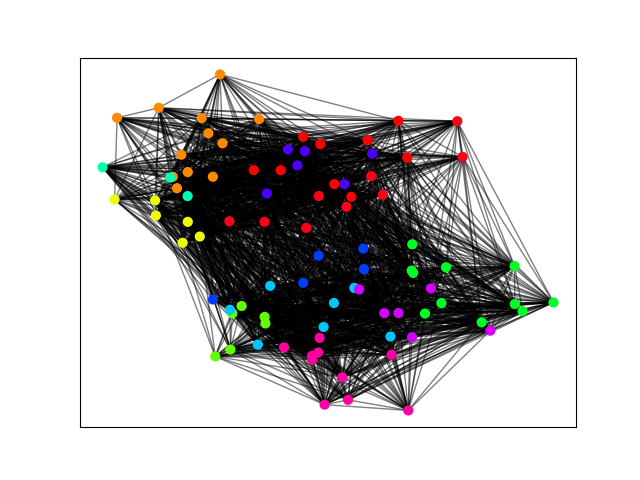

In [3]:
%matplotlib notebook
# compute the best partition
partition = community_louvain.best_partition(G, weight='weight', resolution=0.5)

# color the nodes according to their partition
cmap = cm.get_cmap('hsv', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

Let's visualize these nodes on the original atlas. The atlas used is the AAL atlas, without cerebellum and vermis area. In other words, AAL 116, with the first 90 regions used.
Let's take these regions, compute their coordinates, and use it to display our nodes on these coordinates.

In [6]:
aal = fetch_atlas_aal()
# Get coordinates of the regions in AAL atlas and their corresponding labels
coordinates, label_list = plotting.find_parcellation_cut_coords(labels_img=aal['maps'], return_label_names=True) # Note that we compute coordinates for all 116 nodes here, but it doesn't really matter

# Re-order coordinates in sorted order of labels, so that they match with the original atlas' order
coords = coordinates[np.argsort(label_list)]

# We only consider the first 90 regions and ignore cerebellum
limit = 90

def plot_markers_based_on_partition(coords, partition, cmap, output_name='community_example.html'):
    """
    Given markers (defined by their coordinates) as well as a color map function and a partition vector, plot in 
    interactive 3D plot markers in MNI space, overlaid on a glass brain.
    The visualization is saved in the Results subdirectory as an HTML file with the provided name.
    :param coords: 3D coordinates of each marker in MNI space (should be N x 3, where N the number of markers)
    :param partition: Nx1 vector of assignments, denoting for each marker its community
    :param cmap: Colormap function
    :param output_name: Name under which to save visualization. (Default: community_example.html)
    :return: 
    """
    # Plot first 90 region coordinates. Each node is colored according to its community value
    view = plotting.view_markers(coords, cmap(list(partition.values()))) 
    view.save_as_html('../Results/' + output_name)
    view.open_in_browser()
    return view
    
plot_markers_based_on_partition(coords[:limit], list(partition.values())[:limit], cmap)

AttributeError: 'list' object has no attribute 'values'